<a href="https://colab.research.google.com/github/HikaruEgashira/pytorch-tutorial/blob/master/04_cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


分類分けの学習Training a Classifier
=====================

ここではニューラルネットワークの定義方法、損失の計算、重みの更新を教える
まず以下のことについて考えて見てください

データとは何か？
----------------

一般的に画像、文字、音声、動画データを取り扱わなければなりません。
まずpythonのパッケージでデータをnumpyの配列に読み込み
その後`torch.*Tensor`に変形します。

-  画像はPillow, OpenCV
-  音声はcsipy, librosa
-  文字はPythonやCythonの文字列読み込みやNLTKのSpaCy


``torchvision`にImagenet, CIFAR10, MNISTなどの共通データのデータローダがある。
``torchvision.datasets`` and ``torch.utils.data.DataLoader``には画像を変形したデータがある。

それらを使うことで共通したデータ読み込みのコードを書く手間を省いています。

このチュートリアルではCIFAR10という
‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck‘のデータセットを使う
サイズは 3x32x32
3はRGB
32x32はピクセル

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


画像分類の学習Training an image classifier
----------------------------

手順

1. ``torchvision``でデータセットの読み込み  
2. 畳み込みネットワークを定義
3. 損失関数を定義
4. 学習データを使い学習
5. テストデータを使いテスト


1. データの読み込みと正規化
    torchvision+DataLoader

``torchvision``がCIFAR10では一番楽.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvisionは[0, 1]で出力されるため
[-1, 1]に正規化を行う

In [15]:
# 正規化を定義。今回はTensor型にした後、上で説明した正規化を行う
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# root: path, train: 学習データはTrue, テストデータはFalse
# download=True, transform: transform.Composeしたのをここで呼び出す
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# DataLoader: 読み込み後に行う
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# 今回分類するものを先にタプルで書きだしておく
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


学習画像の表示

 ship plane  bird truck


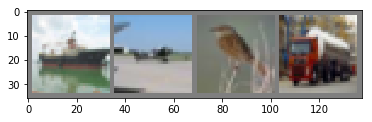

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 画像を表示する関数

def imshow(img):
    img = img / 2 + 0.5     # 非正規化 unnormalize
    npimg = img.numpy()     # numpy配列に変換
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 学習データをランダムに取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像を表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. 畳み込みの実装 Define a Convolution Neural Network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # 初期状態にネットワークの次元の定義
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # reluはnn.functionalで定義されている
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. 損失関数と最適化関数を定義する


分類クロスエントロピーとSDGを今回は使う


In [0]:
# 弾み値を用いたSGDの最適化関数を使うのに用いる
import torch.optim as optim

# 分類分けクロスエントロピー
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4.学習


データセット上で何度もネットワークへの入力と最適化を繰り返す

In [19]:
for epoch in range(2):  # 複数回繰り返す（エポック数の定義）

    running_loss = 0.0
    # データごとのループ
    for i, data in enumerate(trainloader, 0):
        # 入力を得る
        inputs, labels = data

        # こうはいのパラメータをゼロに
        optimizer.zero_grad()

        # forward + backward + optimize
        # ネットクラスに入力データを入れる
        outputs = net(inputs)
        # クロスエントロピーでの損失の計算
        loss = criterion(outputs, labels)
        # 逆伝搬
        loss.backward()
        # 最適化関数の処理
        optimizer.step()

        # 統計の出力
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000をミニバッチとする
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            # ミニバッチごとの損失なので初期化
            running_loss = 0.0
# エポック数行った
print('Finished Training')

[1,  2000] loss: 2.222
[1,  4000] loss: 1.875
[1,  6000] loss: 1.679
[1,  8000] loss: 1.586
[1, 10000] loss: 1.516
[1, 12000] loss: 1.464
[2,  2000] loss: 1.386
[2,  4000] loss: 1.367
[2,  6000] loss: 1.328
[2,  8000] loss: 1.320
[2, 10000] loss: 1.324
[2, 12000] loss: 1.271
Finished Training


5. テストデータでのテスト確認


学習データ上を二周学習したのでこの学習が正確かどうかのテストを行う

出力のラベルを予測して確認を行い、正しければ正しい予測を行ったサンプルリストに追加する

1. テストセットの視覚化


GroundTruth:    cat  ship  ship plane


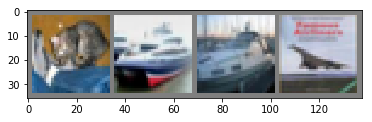

In [20]:
# 読み込みはiterのnext関数で
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像の表示はimshowで
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

これらの例をニューラルネットワークがどう解釈するのか見てみる

In [0]:
# 画像群をネットに入れて出力をみる
outputs = net(images)

もっとも値の大きい物が10のクラスの中で妥当だと解釈したものなので、その番号を得る

In [22]:
# tensor配列の最大を出力
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


テスト全体で見ていこう

In [23]:
correct = 0
total = 0
# テスト中は学習しないのでこうはいをしない設定にすることで時間を短縮する
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # 予測とラベルが等しいものの合計値を出力
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


ランダムだと10%になるので何かしらの学習のあとが見られますね。

うまくいったものとそうでないものは何かをみていく

In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # squeeze関数のあとにラベル4つで行っている操作が分かりません
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 79 %
Accuracy of  bird : 38 %
Accuracy of   cat : 21 %
Accuracy of  deer : 58 %
Accuracy of   dog : 43 %
Accuracy of  frog : 49 %
Accuracy of horse : 74 %
Accuracy of  ship : 68 %
Accuracy of truck : 53 %


GPUを使った学習
----------------
CUDAの利用できるデバイスがあるかどうかの確認

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDAがあると想定して、そのデバイスを出力する。なければcpuと出力されます

print(device)

cpu


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


